In [2]:
import pandas as pd
import yaml
import torch
from model import YNet
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from utils.dataloader import SceneDataset, scene_collate
from utils.preprocessing import create_images_dict
from utils.image_utils import (
    resize,
    pad,
    preprocess_image_for_segmentation,
    create_dist_mat,
)
from predict import predict
from mt import (
    flip_in_bounds,
    rotate_around_point_torch,
    rotate_around_point_np,
    calculate_distances,
    calculate_displacement,
    calculate_displacement_mean,
    z_score,
    flip_ud_reproj,
    flip_lr_reproj,
    resize_reproj,
    rotate_reproj,
    rotate_tensor,
)
import scipy.special

import itertools
import json

In [3]:
%load_ext autoreload
%autoreload 2

#### Some hyperparameters and settings

In [4]:
## Longterm Prediction Setting
# CONFIG_FILE_PATH = 'config/sdd_longterm.yaml'  # yaml config file containing all the hyperparameters
# DATASET_NAME = 'sdd'

# TEST_DATA_PATH = 'data/SDD/test_longterm.pkl'
# TEST_IMAGE_PATH = 'data/SDD/test'
# OBS_LEN = 5  # in timesteps
# PRED_LEN = 30  # in timesteps
# NUM_GOALS = 20  # K_e
# NUM_TRAJ = 5  # K_a

## Shortterm Prediction Setting
CONFIG_FILE_PATH = (
    "config/sdd_trajnet.yaml"  # yaml config file containing all the hyperparameters
)
DATASET_NAME = "sdd"

TEST_DATA_PATH = "data/SDD/test_trajnet.pkl"
TEST_IMAGE_PATH = "data/SDD/test"  # only needed for YNet, PECNet ignores this value
OBS_LEN = 8  # in timesteps
PRED_LEN = 12  # in timesteps
NUM_GOALS = 20  # K_e
NUM_TRAJ = 1  # K_a

## General Settings
ROUNDS = 3  # Y-net is stochastic. How often to evaluate the whole dataset
BATCH_SIZE = 8

## Testing Settings
ROUNDS_VARIATION = 8  # N
RESIZE_PARAMS = (0.2, 0.3)
ROTATION_PARAMS = (90, 180, 270)

#### Load config file and print hyperparameters

In [5]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
experiment_name = CONFIG_FILE_PATH.split(".yaml")[0].split("config/")[1]
params

{'resize': 0.25,
 'batch_size': 8,
 'viz_epoch': 10,
 'learning_rate': 0.0001,
 'num_epochs': 300,
 'encoder_channels': [32, 32, 64, 64, 64],
 'decoder_channels': [64, 64, 64, 32, 32],
 'waypoints': [11],
 'temperature': 1.0,
 'segmentation_model_fp': 'segmentation_models/SDD_segmentation.pth',
 'semantic_classes': 6,
 'loss_scale': 1000,
 'kernlen': 31,
 'nsig': 4,
 'use_features_only': False,
 'unfreeze': 150,
 'use_TTST': True,
 'rel_threshold': 0.01,
 'use_CWS': False,
 'CWS_params': 'None'}

#### Load preprocessed Data

In [6]:
df_test = pd.read_pickle(TEST_DATA_PATH)

In [7]:
df_test.head()

frame  trackId       x      y  sceneId  metaId
0      0     28.0  1539.5  578.0  coupa_0       0
1     12     28.0  1484.5  576.0  coupa_0       0
2     24     28.0  1484.5  576.0  coupa_0       0
3     36     28.0  1459.5  571.0  coupa_0       0
4     48     28.0  1432.5  569.0  coupa_0       0

In [8]:
df_test.shape

(56580, 6)

In [9]:
# Preparation code from `model.evaluate`
device = None
dataset_name = DATASET_NAME
image_path = TEST_IMAGE_PATH
batch_size = BATCH_SIZE
rounds = (ROUNDS,)
num_goals = NUM_GOALS
num_traj = NUM_TRAJ

if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_len = OBS_LEN
pred_len = PRED_LEN
total_len = pred_len + obs_len

division_factor = 2 ** len(params["encoder_channels"])

print("Preprocess data")
dataset_name = dataset_name.lower()
if dataset_name == "sdd":
    image_file_name = "reference.jpg"
elif dataset_name == "ind":
    image_file_name = "reference.png"
elif dataset_name == "eth":
    image_file_name = "oracle.png"
else:
    raise ValueError(f"{dataset_name} dataset is not supported")

# ETH/UCY specific: Homography matrix is needed to convert pixel to world coordinates
if dataset_name == "eth":
    # ynet_model.homo_mat = {}
    # for scene in ['eth', 'hotel', 'students001', 'students003', 'uni_examples', 'zara1', 'zara2', 'zara3']:
    #     ynet_model.homo_mat[scene] = torch.Tensor(np.loadtxt(f'data/eth_ucy/{scene}_H.txt')).to(device)
    seg_mask = True
else:
    # ynet_model.homo_mat = None
    seg_mask = False

test_images = create_images_dict(
    df_test, image_path=image_path, image_file=image_file_name
)
test_images_orig = create_images_dict(
    df_test, image_path=image_path, image_file=image_file_name
)
resize(test_images_orig, factor=params["resize"], seg_mask=seg_mask)

# test_dataset = SceneDataset(df_test, resize=params['resize'], total_len=total_len)
# test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=scene_collate)

# Preprocess images, in particular resize, pad and normalize as semantic segmentation backbone requires
resize(test_images, factor=params["resize"], seg_mask=seg_mask)

# Size before padding, needed to extract segmentation map for manipulation
size_unpadded = {k: v.shape for k, v in test_images.items()}

pad(
    test_images, division_factor=division_factor
)  # make sure that image shape is divisible by 32, for UNet architecture
preprocess_image_for_segmentation(test_images, seg_mask=seg_mask)

# model = ynet_model.model.to(device)

# Create template
size = int(4200 * params["resize"])

input_template = torch.Tensor(create_dist_mat(size=size)).to(device)


# Rescale preparation
rescale_mr = {}

for resize_param in RESIZE_PARAMS:
    test_images_r = create_images_dict(
        df_test, image_path=image_path, image_file=image_file_name
    )
    resize(test_images_r, factor=resize_param, seg_mask=seg_mask)

    size_unpadded_resized = {k: v.shape for k, v in test_images_r.items()}

    pad(test_images_r, division_factor=division_factor)
    preprocess_image_for_segmentation(test_images_r, seg_mask=seg_mask)
    rescale_mr[resize_param] = (test_images_r, size_unpadded_resized)

Preprocess data


In [10]:
df_test[["sceneId", "trackId"]].groupby("sceneId").nunique()

trackId
sceneId          
coupa_0       323
coupa_1       235
gates_2       155
hyang_0       630
hyang_1       427
hyang_3        61
hyang_8        12
little_0       52
little_1      110
little_2       42
little_3      362
nexus_5        14
nexus_6       334
quad_0         10
quad_1         20
quad_2         30
quad_3         12

In [11]:
scene = "little_1"
track_id = 28
input_trajectory = [
    df_test[(df_test.sceneId == scene) & (df_test.trackId == track_id)][
        ["x", "y"]
    ].values
]

In [12]:
cx = size_unpadded[scene][1] / 2
cy = size_unpadded[scene][0] / 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


torch.Size([512, 352, 3]) (352, 512, 3)


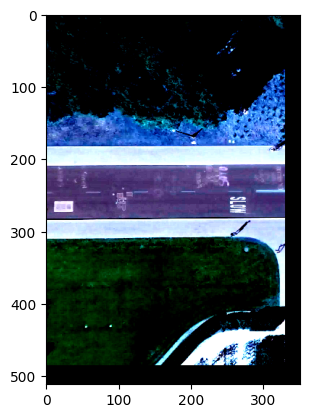

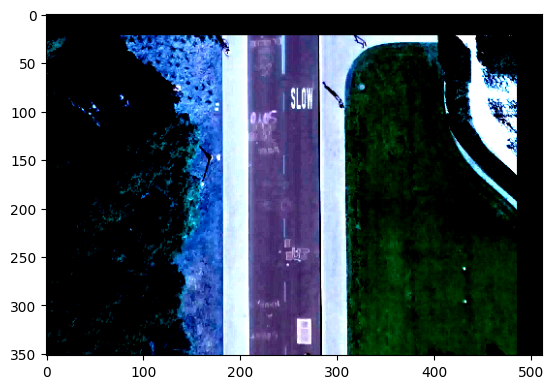

In [13]:
from scipy import ndimage
img = np.transpose(test_images[scene], (1, 2, 0))
img2 = ndimage.rotate(img, 90, axes=(1, 0), reshape=True)

print(img.shape, img2.shape)

plt.imshow(img)

plt.figure()
plt.imshow(img2)

assert (img == ndimage.rotate(img2, -90, axes=(1, 0), reshape=True)).all()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
/var/folders/rf/xz0f5yz96cb_qq_gcl42zqvw0000gn/T/ipykernel_2194/1065787444.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ipf), degrees=-180, origin=(cx, cy)


(array([[ 446. , 1174.5],
        [ 462. , 1174.5],
        [ 477. , 1174.5],
        [ 493. , 1178.5],
        [ 512. , 1178.5],
        [ 530. , 1178.5],
        [ 547. , 1178.5],
        [ 565. , 1178.5],
        [ 583. , 1178.5],
        [ 600. , 1182.5],
        [ 618. , 1182.5],
        [ 638.5, 1186.5],
        [ 660.5, 1186.5],
        [ 682.5, 1186.5],
        [ 703. , 1182.5],
        [ 725. , 1182.5],
        [ 747. , 1182.5],
        [ 767. , 1178.5],
        [ 789. , 1178.5],
        [ 811. , 1178.5]]),
 tensor([[ 446.0000, 1174.5000],
         [ 462.0000, 1174.5000],
         [ 477.0000, 1174.5000],
         [ 493.0000, 1178.5000],
         [ 512.0000, 1178.5000],
         [ 530.0000, 1178.5000],
         [ 547.0000, 1178.5000],
         [ 565.0000, 1178.5000],
         [ 583.0000, 1178.5000],
         [ 600.0000, 1182.5000],
         [ 618.0000, 1182.5000],
         [ 638.5000, 1186.5000],
         [ 660.5000, 1186.5000],
         [ 682.5000, 1186.5000],
         [ 703.0

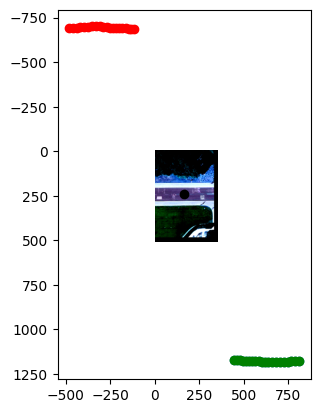

In [14]:
ipf = rotate_around_point_torch(
    torch.tensor(input_trajectory[0]), degrees=180, origin=(cx, cy)
)
plt.imshow(np.transpose(test_images[scene], (1, 2, 0)))
plt.scatter(input_trajectory[0][:, 0], input_trajectory[0][:, 1])
plt.scatter(cx, cy, c="black")
plt.scatter(ipf[:, 0], ipf[:, 1], c="red")

ipf2 = rotate_around_point_torch(
    torch.tensor(ipf), degrees=-180, origin=(cx, cy)
)
plt.scatter(ipf2[:, 0], ipf2[:, 1], c="green")
assert np.isclose(input_trajectory[0], ipf2).all()
input_trajectory[0], ipf2







In [15]:
import imageio.v3 as iio
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum


def plot_map(class_labels, class_labels2=None):
    num_labels = 6  # np.max(class_labels) + 1
    max_label = num_labels - 1

    # Create a color map with distinct colors for each class
    cmap = plt.get_cmap("tab10", num_labels)  # 'tab10' colormap has 10 distinct colors

    # Convert class labels to RGB colors using the colormap
    colored_image = cmap(class_labels / max_label)

    colors = [cmap(i / (num_labels - 1)) for i in range(num_labels)]

    if class_labels2 is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        colored_image2 = cmap(class_labels2 / max_label)
        ax1.imshow(colored_image, aspect="auto")
        ax2.imshow(colored_image2, aspect="auto")
        ax1.set_title("Original")
        ax2.set_title("Modified")
        ax1.axis("off")
        ax2.axis("off")
    else:
        plt.figure()
        plt.imshow(colored_image, aspect="auto")

    # 0 - background (blue)
    # 1 - pavement (green)
    # 2 - road (purple)
    # 3 - structure (pink)
    # 4 - terrain (yellow)
    # 5 - tree (turkis/teal)

    labels = ["Background", "Pavement", "Road", "Structure", "Terrain", "Tree"]
    patches = [
        mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
    ]

    if class_labels2 is not None:
        fig.legend(handles=patches, loc="center right")
    else:
        plt.legend(handles=patches, loc="upper right")

    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("segmentation.pdf", dpi=400, bbox_inches="tight")
    plt.show()


# data = iio.imread("data/SDD_semantic_maps/test_masks/little_1_mask.png")
data = iio.imread("data/SDD_semantic_maps/test_masks/coupa_1_mask.png")

# data = np.random.randint(0, 5 + 1, size=(10, 10))

print(data.shape)
class_labels = np.squeeze(data)

(1093, 1980)


Changing structure (3) to terrain (4) - more_walkable (2.7% of pixels)
('structure', 'terrain', <ClassChangeType.MORE_WALKABLE: 'more_walkable'>, 58852)


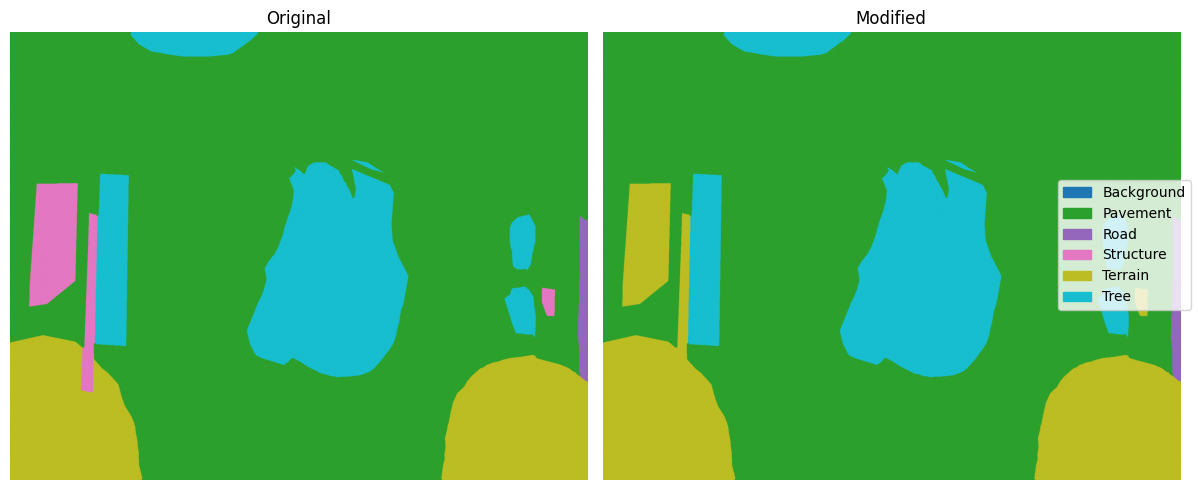

In [20]:
class ClassChangeType(Enum):
    LESS_WALKABLE = "less_walkable"
    MORE_WALKABLE = "more_walkable"
    OBSTACLE = "obstacle"


segmentation_class_map = {
    "background": 0,
    "pavement": 1,
    "road": 2,
    "structure": 3,
    "terrain": 4,
    "tree": 5,
}


def random_class_change(class_labels):
    class_changes = [
        ("pavement", "road", ClassChangeType.LESS_WALKABLE),
        ("terrain", "road", ClassChangeType.LESS_WALKABLE),
        ("road", "pavement", ClassChangeType.MORE_WALKABLE),
        ("road", "terrain", ClassChangeType.MORE_WALKABLE),
        ("terrain", "pavement", ClassChangeType.MORE_WALKABLE),
        ("pavement", "terrain", ClassChangeType.LESS_WALKABLE),
        ("structure", "road", ClassChangeType.MORE_WALKABLE),
        ("structure", "pavement", ClassChangeType.MORE_WALKABLE),
        ("structure", "terrain", ClassChangeType.MORE_WALKABLE),
        ("tree", "road", ClassChangeType.MORE_WALKABLE),
        ("tree", "pavement", ClassChangeType.MORE_WALKABLE),
        ("tree", "terrain", ClassChangeType.MORE_WALKABLE),
        ("road", "structure", ClassChangeType.OBSTACLE),
        ("road", "tree", ClassChangeType.OBSTACLE),
        ("pavement", "structure", ClassChangeType.OBSTACLE),
        ("pavement", "tree", ClassChangeType.OBSTACLE),
        ("terrain", "structure", ClassChangeType.OBSTACLE),
        ("terrain", "tree", ClassChangeType.OBSTACLE),
    ]

    class_labels_modified = class_labels.copy()

    # Randomly select a change from the list
    class_change_idx = np.random.choice(len(class_changes))
    src_class, tgt_class, change_type = class_changes[class_change_idx]

    src_idx = segmentation_class_map[src_class]
    tgt_idx = segmentation_class_map[tgt_class]

    condition = class_labels_modified == src_idx
    class_labels_modified[condition] = tgt_idx
    affected_area = int(condition.sum())

    print(
        f"Changing {src_class} ({src_idx}) to {tgt_class} ({tgt_idx}) - {change_type.value} ({affected_area / class_labels_modified.size * 100:.1f}% of pixels)"
    )

    return class_labels_modified, (src_class, tgt_class, change_type, affected_area)


class_labels2, change_info = random_class_change(class_labels)

print(change_info)

plot_map(class_labels, class_labels2)

# TODO Evaluation of the MR

In [17]:
df_test[(df_test.sceneId == scene) & (df_test.trackId == track_id)]

frame  trackId      x       y   sceneId  metaId
39560   9696     28.0  446.0  1174.5  little_1    1978
39561   9708     28.0  462.0  1174.5  little_1    1978
39562   9720     28.0  477.0  1174.5  little_1    1978
39563   9732     28.0  493.0  1178.5  little_1    1978
39564   9744     28.0  512.0  1178.5  little_1    1978
39565   9756     28.0  530.0  1178.5  little_1    1978
39566   9768     28.0  547.0  1178.5  little_1    1978
39567   9780     28.0  565.0  1178.5  little_1    1978
39568   9792     28.0  583.0  1178.5  little_1    1978
39569   9804     28.0  600.0  1182.5  little_1    1978
39570   9816     28.0  618.0  1182.5  little_1    1978
39571   9828     28.0  638.5  1186.5  little_1    1978
39572   9840     28.0  660.5  1186.5  little_1    1978
39573   9852     28.0  682.5  1186.5  little_1    1978
39574   9864     28.0  703.0  1182.5  little_1    1978
39575   9876     28.0  725.0  1182.5  little_1    1978
39576   9888     28.0  747.0  1182.5  little_1    1978
39577   9900     28.0  767.0  1178.5  little_1    1978
39578   9912     28.0  789.0  1178.5  little_1    1978
39579   9924     28.0  811.0  1178.5  little_1    1978

Add structure obstacle with size 20 at distance 0.60 from the trajectory


(np.True_, np.False_)

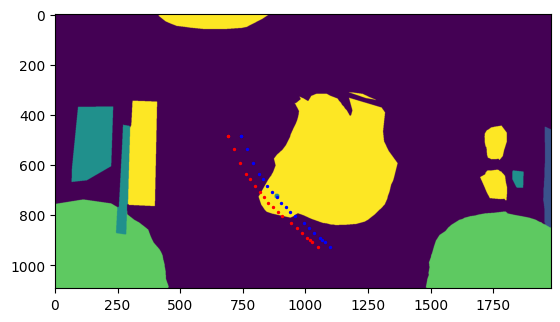

In [19]:
from utils.dataloader import SceneDataset, scene_collate
from torch.utils.data import DataLoader
import pandas as pd
from utils.preprocessing import create_images_dict




TEST_DATA_PATH = "data/SDD/test_trajnet.pkl"

df = df_test[(df_test.sceneId == scene) & (df_test.trackId == 3)]

trajectory = df[["x", "y"]].values

# Parameters
distance = np.random.random()
obstacle_size = np.random.choice(np.arange(10, 120, 10))
obstacle_class = list(segmentation_class_map.keys())[np.random.choice(len(segmentation_class_map))]

print(f"Add {obstacle_class} obstacle with size {obstacle_size} at distance {distance:.2f} from the trajectory")
class_labels_with_obstacle, full_obstacle_mask = add_obstacle(class_labels, trajectory, distance=distance, obstacle_size=obstacle_size, obstacle_class=obstacle_class)

# TODO Create evaluation with probability distributions
traj_s = trajectory.copy()

traj_f = trajectory.copy()
traj_f[:, 0] -= 50

# Plot the data
plt.figure()

plt.imshow(class_labels)
plt.imshow(class_labels_with_obstacle)

plt.scatter(traj_s[:, 0], traj_s[:, 1], s=2, color="blue")
plt.scatter(traj_f[:, 0], traj_f[:, 1], s=2, color="red")

check_intersection(traj_s, full_obstacle_mask), check_intersection(traj_f, full_obstacle_mask)

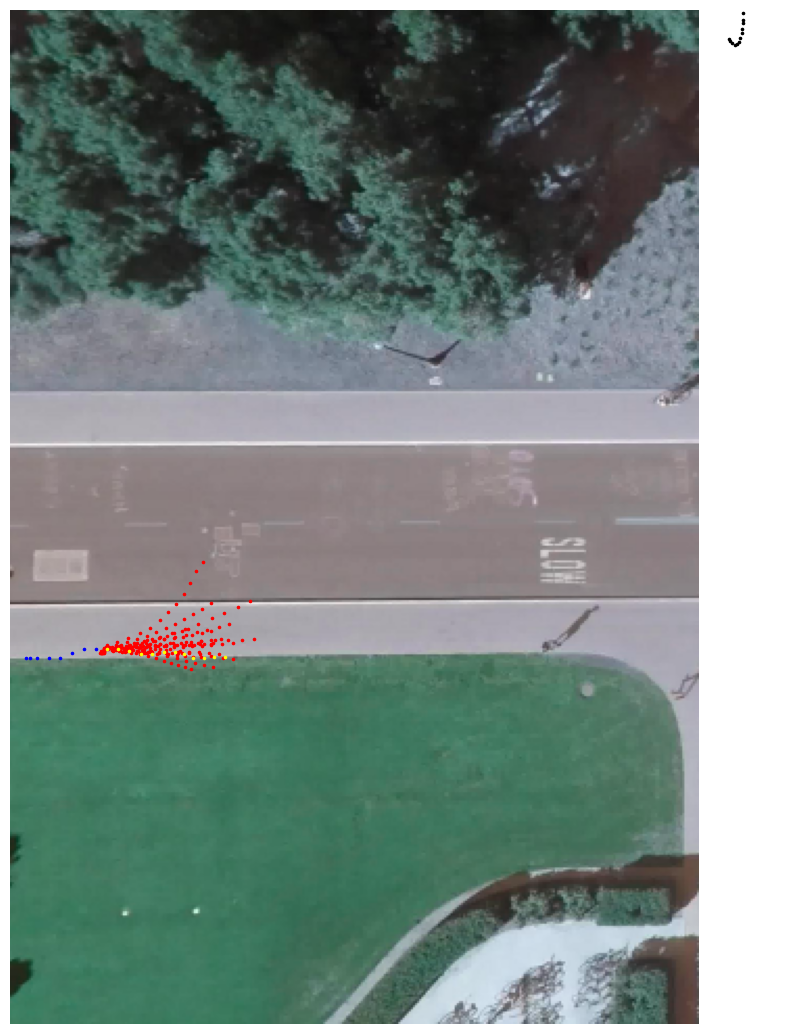

In [84]:
# For plotting, pick one trajectory
ix = 0
inp = input_trajectory[ix]
pred = pred_traj[ix]
truth = gt_future[ix]
heatmap = pred_waypoint_map_sigmoid[ix, -1]

inp_f = input_trajectory_f_re[ix]
pred_f = pred_traj_f[ix]
# truth_f = gt_future[ix]
heatmap_f = pred_waypoint_map_sigmoid_f_re[ix, -1]

plt.figure(figsize=(8, 12))

# plt.imshow(np.flip(test_images_orig[scene_name], axis=1))
plt.imshow(test_images_orig[scene_name])
# plt.imshow(
#     heatmap,
#     cmap="bwr",
#     interpolation="nearest",
#     alpha=0.2,
# )

# plt.imshow(
#     heatmap_f,
#     cmap="PRGn",
#     interpolation="nearest",
#     alpha=0.2,
# )

scatter_size = 2.5

plt.scatter(inp[:, 0], inp[:, 1], c="blue", s=scatter_size, label="Past Trajectory")

plt.scatter(
    future_samples[:, ix, :, 0],
    future_samples[:, ix, :, 1],
    c="red",
    s=scatter_size,
    label="Predicted Trajectories",
    # marker=">",
    # alpha=0.5,
)
# plt.scatter(
#     future_samples_f_re[:, ix, :, 0],
#     future_samples_f_re[:, ix, :, 1],
#     c="green",
#     s=scatter_size,
#     label="Follow-Up (alt)",
#     # marker="x",
#     alpha=0.5,
# )

# plt.scatter(pred[:, 0], pred[:, 1], c="red", s=scatter_size, label="Source")
plt.scatter(truth[:, 0], truth[:, 1], c="yellow", s=scatter_size, label="Truth")


plt.scatter(pred_f[:, 0], pred_f[:, 1], c="black", s=scatter_size, label="Follow-Up")
# plt.scatter(
#     inp_f[:, 0],
#     inp_f[:, 1],
#     c="purple",
#     s=scatter_size,
# )
# plt.legend()
plt.axis("off")
# plt.scatter(
#     waypoint_samples[:, ix, -1:, 0],
#     waypoint_samples[:, ix, -1:, 1],
#     c="brown",
#     s=5,
# )

# plt.scatter(
#     waypoint_samples_ff[:, ix, -1:, 0],
#     waypoint_samples_ff[:, ix, -1:, 1],
#     c="purple",
#     s=5,
# )
plt.tight_layout()
# plt.savefig("traj-inp-out.pdf", dpi=400, bbox_inches="tight")
fig = plt.gcf()
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [63]:
import cv2

res = cv2.resize(data, dsize=(800, 600))
cv2.imwrite("input-output-example.png", cv2.cvtColor(res, cv2.COLOR_RGB2BGR))

True

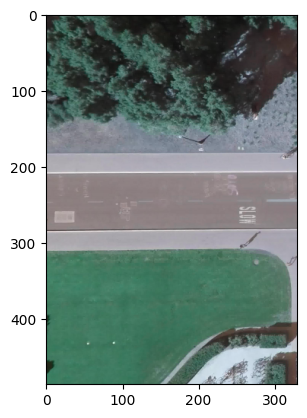

In [42]:
plt.imshow(test_images_orig[scene_name])

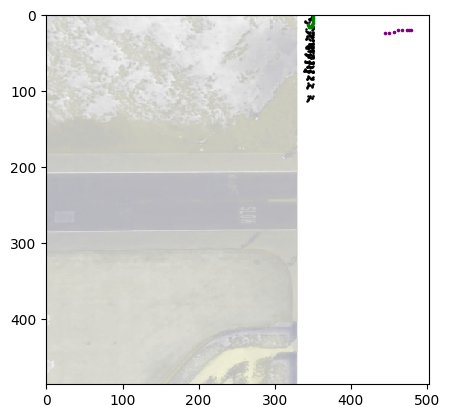

In [85]:
inp_f = input_trajectory_f[ix]
pred_f = pred_traj_f[ix]
# truth_f = gt_future[ix]
heatmap_f = pred_waypoint_map_sigmoid_f[ix, -1]

plt.imshow(
    rotate_tensor(
        torch.from_numpy(test_images_orig[scene_name]), 90, size_unpadded[scene]
    ).transpose(1, 2)
)


# plt.imshow(
#     np.flip(heatmap_f, 0),  # Flip in original bounds
#     cmap="PRGn",
#     interpolation="nearest",
#     alpha=0.2,
# )
plt.scatter(
    future_samples_f[:, ix, :, 0],
    future_samples_f[:, ix, :, 1],
    c="black",
    s=scatter_size / 4,
    # marker="+",
)


plt.scatter(
    pred_f[:, 0],
    pred_f[:, 1],
    c="green",
    s=scatter_size,
)
plt.scatter(
    inp_f[:, 0],
    inp_f[:, 1],
    c="purple",
    s=scatter_size,
)


/tmp/ipykernel_427796/3741601780.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


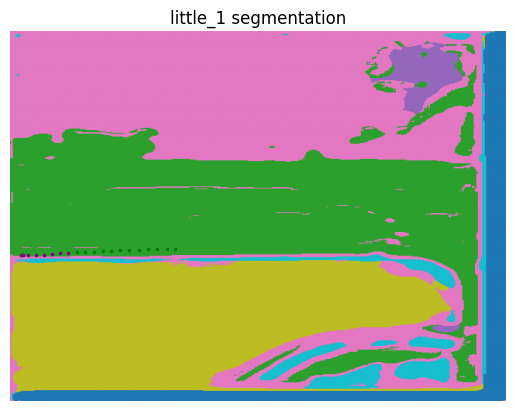

In [86]:
# .shape
# plt.imshow(scene_image_segm)
data = np.transpose(scene_image_segm.cpu().numpy().argmax(axis=1), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")
# plt.legend()
# plt.show()

plt.scatter(
    pred[:, 0],
    pred[:, 1],
    c="green",
    s=scatter_size,
)
plt.scatter(
    inp[:, 0],
    inp[:, 1],
    c="purple",
    s=scatter_size,
)

243.0 165.0 [[478.75      20.124985]
 [477.125     20.124985]
 [473.5       20.124985]
 [468.        20.124985]
 [462.5       20.124985]
 [457.        22.124985]
 [451.        24.124985]
 [445.5       24.124985]]


/tmp/ipykernel_427796/3425724676.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


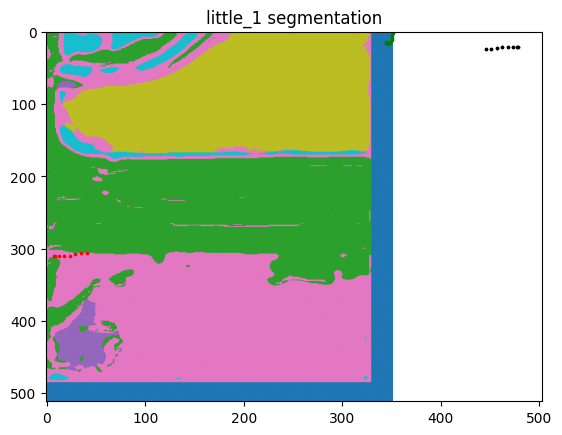

In [87]:
# .shape
# plt.imshow(scene_image_segm)

center_x = size_unpadded[scene][0] / 2
center_y = size_unpadded[scene][1] / 2
inp_f2 = (
    rotate_around_point_torch(
        torch.from_numpy(input_trajectory[0]),
        degrees=rotation_param,
        origin=(center_x, center_y),
    )
    .cpu()
    .numpy()
)

print(center_x, center_y, inp_f2)

data = np.transpose(scene_image_segm_f.argmax(axis=1), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
# plt.axis('off')
# plt.legend()
# plt.show()

plt.scatter(
    pred_f[:, 0],
    pred_f[:, 1],
    c="green",
    s=scatter_size,
)
plt.scatter(
    inp[:, 0],
    inp[:, 1],
    c="red",
    s=scatter_size,
)
plt.scatter(
    inp_f[:, 0],
    inp_f[:, 1],
    c="purple",
    s=scatter_size,
)
plt.scatter(
    inp_f2[:, 0],
    inp_f2[:, 1],
    c="black",
    s=scatter_size,
)

/tmp/ipykernel_335763/2420222151.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


(-0.5, 351.5, 511.5, -0.5)

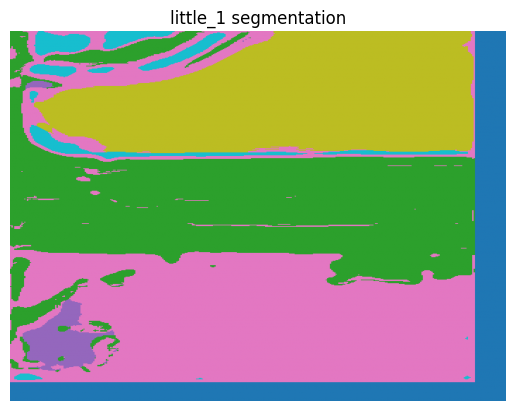

In [55]:
# .shape
# plt.imshow(scene_image_segm)
import torch


plt.figure()
data = np.transpose(
    rotate_tensor(scene_image_segm, 180, size_unpadded[scene])
    .argmax(axis=1)
    .cpu()
    .numpy(),
    (1, 2, 0),
)
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")
# plt.legend()
# plt.show()

In [57]:
40 not in {30, 100, 10}

True

(-0.5, 351.5, 511.5, -0.5)

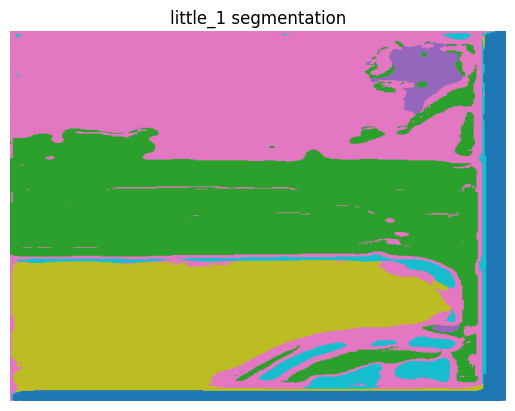

In [31]:
data = np.transpose(scene_image_segm.argmax(axis=1).cpu().numpy(), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")

In [1]:
import imageio.v3 as iio
import matplotlib.patches as mpatches

data = iio.imread("data/SDD_semantic_maps/test_masks/little_1_mask.png")
# data = iio.imread('data/SDD_semantic_maps/test_masks/coupa_1_mask.png')
print(data.shape)
class_labels = np.squeeze(data)

num_labels = np.max(class_labels) + 1

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))

colors = [cmap(i / (num_labels - 1)) for i in range(num_labels)]

plt.imshow(colored_image, aspect="auto")
# plt.title(f"{scene} segmentation")

# 0 - background (blue)
# 1 - pavement (green)
# 2 - road (purple)
# 3 - structure (pink)
# 4 - terrain (yellow)
# 5 - tree (turkis/teal)

labels = ["Background", "Pavement", "Road", "Structure", "Terrain", "Tree"]
patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]

plt.legend(handles=patches, loc="upper right")

plt.axis("off")
plt.tight_layout()
plt.savefig("segmentation.pdf", dpi=400, bbox_inches="tight")
# plt.show()

ModuleNotFoundError: No module named 'imageio'

In [23]:
(
    input_trajectory.shape,
    pred_traj.shape,
    gt_future.shape,
    pred_waypoint_map_sigmoid.shape,
)

(torch.Size([6, 5, 2]),
 torch.Size([6, 30, 2]),
 torch.Size([6, 30, 2]),
 torch.Size([6, 2, 512, 352]))

In [24]:
# predict_and_evaluate(
#     model,
#     test_loader,
#     test_images,
#     num_goals,
#     num_traj,
#     obs_len=obs_len,
#     batch_size=batch_size,
#     device=device,
#     input_template=input_template,
#     waypoints=params["waypoints"],
#     resize=params["resize"],
#     temperature=params["temperature"],
#     use_TTST=True,
#     use_CWS=True if len(params["waypoints"]) > 1 else False,
#     rel_thresh=params["rel_threshold"],
#     CWS_params=params["CWS_params"],
#     dataset_name=dataset_name,
#     homo_mat=ynet_model.homo_mat,
#     mode="test",
# )

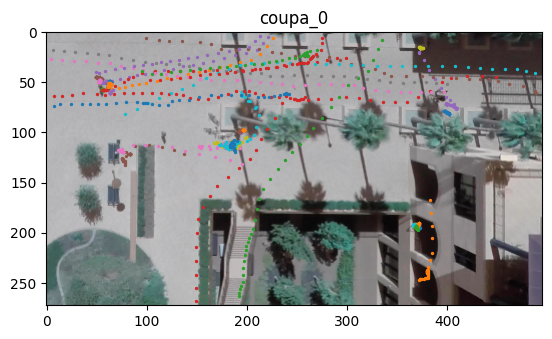

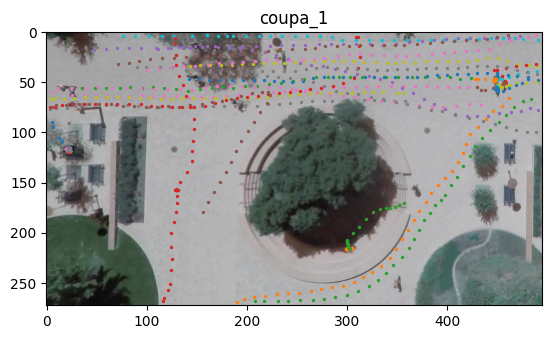

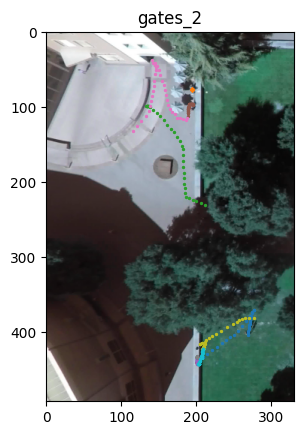

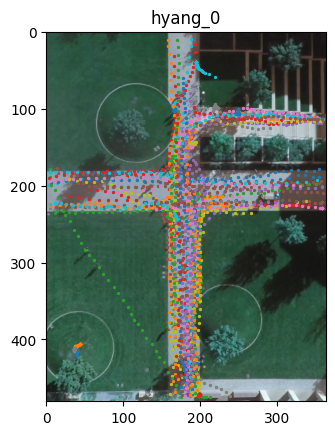

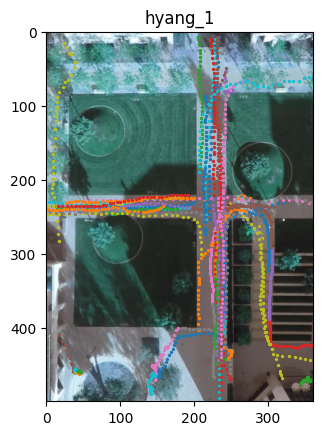

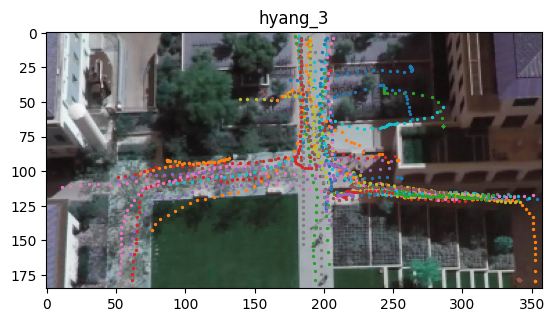

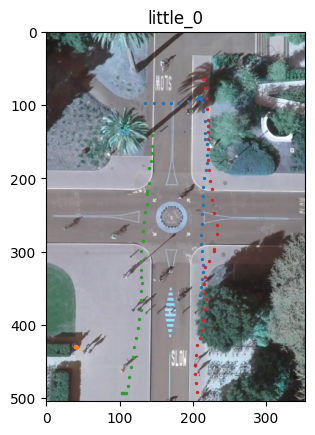

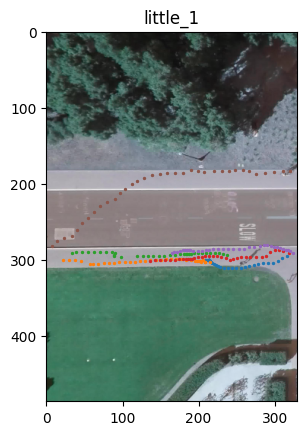

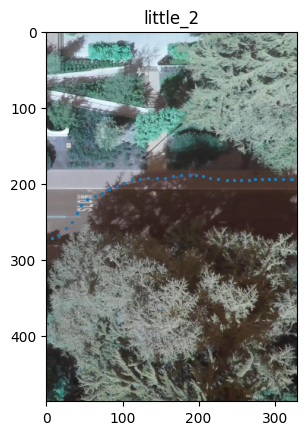

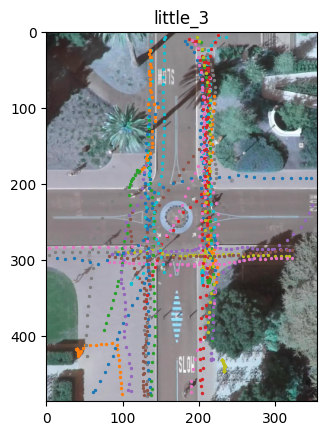

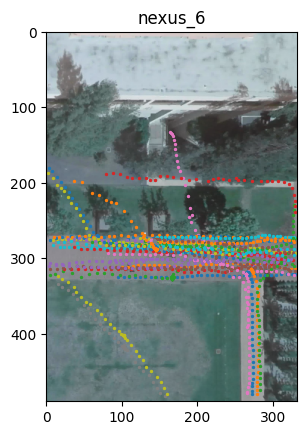

In [25]:
for trajectory, meta, scene in test_loader:
    # print(meta, scene)
    plt.figure()
    plt.title(scene)
    plt.imshow(test_images_orig[scene])

    for t in trajectory:
        plt.scatter(t[:, 0], t[:, 1], s=2)
        # break